In [1]:
import pickle
import boris_extraction as boris
import multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import sem
from itertools import combinations
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.ticker as ticker

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    
phase3_collection = unpickle_this('phase3collection.pkl')

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

c:\Users\megha\anaconda3\envs\ephys_analysis\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Functions

In [6]:
                               
def get_indices(repeated_items_list):
    """
    Takes in an indexed key or a list of repeated items, 
    creates a list of indices that correspond to each unique item.

    Args (1):
        repeated_items_list: list, list of repeated items

    Returns:
        item_indices: list of tuples, where the first element
            is the first index of an item, and the second
            element is the last index of that item
    """
    is_first = True
    item_indices = {}
    for i in range(len(repeated_items_list)):
        if is_first:
            current_item = repeated_items_list[i]
            start_index = 0
            is_first = False
        else:
            if repeated_items_list[i] == current_item:
                end_index = i
                if i == (len(repeated_items_list)-1):
                    item_indices[current_item] = [start_index, end_index]
            else:
                item_indices[current_item] = [start_index, end_index]
                start_index = i
                current_item = repeated_items_list[i]
    return item_indices

def __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events, counter_events = None):
        full_PCA_matrix, t_df, key, coefficients, explained_variance_ratios = phase3_analysis.PCA_matrix_generation(equalize, pre_window, post_window, events = events)
        recordings = full_PCA_matrix.columns.to_list()
        recording_list = np.unique(recordings)
        coefficients = coefficients[:, :no_PCs]
        recording_indices = get_indices(recordings)
        decoder_data = {}
        if counter_events is not None:
            for event in counter_events:
                if event not in events:
                    events.append(event)
        #decoder data dict: events for keys, values is a list of len(events)
        #each element in the list is the transformed matrix
        for recording in recording_list:
            #iterate through recording
            start = recording_indices[recording][0]
            stop = recording_indices[recording][1]
            #trim weight matrix for only those neurons in the current recording
            subset_coeff = coefficients[start:stop+1, :]
            recording_instance = phase3_analysis.ephyscollection.get_by_name(recording)
            for event in events:
                #grab all event firing rates for current event in current recording
                event_firing_rates = phase3_analysis.__get_event_firing_rates__(recording_instance, event,
                                                                equalize, pre_window, post_window)
                for trial in range(len(event_firing_rates)):
                    #iterate through each event
                    trial_data = np.transpose(event_firing_rates[trial])
                    #transpoe event firing rates from neurons x timebins to timebins x neurons
                    transformed_trial = np.dot(trial_data, subset_coeff)
                    #transform each trial with original weight matrix
                    #T (timebins x pcs) = D (timebins x neurons). W (pcs x neurons) 
                    if event in decoder_data.keys():
                        #append transformed matrix to decoder_data1 dict
                        decoder_data[event].append(transformed_trial)
                    else: 
                        decoder_data[event] = []
                        decoder_data[event].append(transformed_trial)
        return decoder_data



def cross_trial_decoder(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, same_event, event1, event2, plot = True):
    decoder_data1 = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = [same_event, event1], counter_events = [event2])
    decoder_data2 = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = [same_event, event2], counter_events = [event1])
    ex_trial_matrix = decoder_data1[same_event][0]
    T = ex_trial_matrix.shape[0]
    auc = {}
    diff_events = [event1, event2]
    decoders = [decoder_data1, decoder_data2]
    for i in [0,1]:  
        data_neg_train = []
        data_neg_test = []
        data_pos = []
        decoder_data = decoders[i]  
        for trial in decoder_data[same_event]:
            data_pos.append(trial)
        for trial in decoder_data[diff_events[i]]:
            data_neg_train.append(trial)
        if i == 0:
            for trial in decoder_data[diff_events[1]]:
                data_neg_test.append(trial)
        else:
            for trial in decoder_data[diff_events[0]]:
                data_neg_test.append(trial)
        data_pos= np.stack(data_pos, axis=2)
        data_neg_train = np.stack(data_neg_train, axis=2)
        data_neg_test = np.stack(data_neg_test, axis=2)
        num_pos = data_pos.shape[2]
        num_neg_train = data_neg_train.shape[2]
        num_neg_test = data_neg_test.shape[2]
        data_pos = data_pos[:, :, np.random.permutation(num_pos)]
        data_neg_train = data_neg_train[:, :, np.random.permutation(num_neg_train)]
        data_neg_test = data_neg_test[:, :, np.random.permutation(num_neg_test)]
        event = diff_events[i]
        auc[event] = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
        for fold in range(num_fold):
            auc_glm = []
            auc_rf = []
            auc_glm_shuffle = []
            auc_rf_shuffle = []
            pos_fold = num_pos // num_fold
            neg_fold_train = num_neg_train // num_fold
            neg_fold_test = num_neg_test // num_fold
            data_test = np.concatenate((data_pos[:, :, fold * pos_fold:(fold + 1) * pos_fold],
                                        data_neg_test[:, :, fold * neg_fold_test:(fold + 1) * neg_fold_test]), axis=2)
            label_test = np.concatenate((np.ones((fold + 1) * pos_fold - fold * pos_fold),
                                        np.zeros((fold + 1) * neg_fold_test - fold * neg_fold_test)))
            data_train = np.concatenate((
                data_pos[:, :, np.setdiff1d(np.arange(num_pos), 
                np.arange(fold * pos_fold, (fold + 1) * pos_fold))],
                data_neg_train[:, :, np.setdiff1d(np.arange(num_neg_train), 
                np.arange(fold * neg_fold_train, (fold + 1) * neg_fold_train))]),
                axis=2)
            label_train = np.concatenate((np.ones(num_pos - (fold + 1) * pos_fold + fold * pos_fold),
                                        np.zeros(num_neg_train - (fold + 1) * neg_fold_train + fold * neg_fold_train)))
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced') 
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
                
                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc[event]['glm'].append(auc_glm)
            auc[event]['rf'].append(auc_rf)
            for shuffle in range(num_shuffle):
                temp_glm_shuffle = []
                temp_rf_shuffle = []
                label_train = np.random.permutation(label_train)
                for timebin in range(T):
                    model_glm = LogisticRegression(class_weight='balanced')
                    model_glm.fit(data_train[timebin, :, :].T, label_train)
                    pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                    temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                    model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                    model_rf.fit(data_train[timebin, :, :].T, label_train)
                    pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                    temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
                auc_glm_shuffle.append(temp_glm_shuffle)
                auc_rf_shuffle.append(temp_rf_shuffle)
            auc[event]['glm_shuffle'].append(auc_glm_shuffle)
            auc[event]['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc__(auc, equalize, pre_window)
    return auc

def trial_decoder_AvB_BvC(equalize, pre_window, post_window, num_fold, num_shuffle, no_PCs, training_events, test_events, plot = True):
    #ugh fuck okay so this gonna take the 4/5 of positive training data, and make it the 1/5 neg data if two events are the same type
    decoder_data = __PCA_for_decoding__(equalize, pre_window, post_window, no_PCs, events = training_events, counter_events = test_events)
    ex_trial_matrix = decoder_data[training_events[0]][0]
    T = ex_trial_matrix.shape[0]
    all_events = list(set(training_events + test_events))
    auc = {}  
    data_A = []
    data_B = []
    data_C = []
    i = 0
    for event in all_events:
        for trial in decoder_data[event]:
            if i == 0: 
                data_A.append(trial)
            if i == 1:
                data_B.append(trial)
            if i == 2:
                data_C.append(trial)
        i+=1
    data_A= np.stack(data_A, axis=2)
    data_B = np.stack(data_B, axis=2)
    data_C = np.stack(data_C, axis=2)
    num_A = data_A.shape[2]
    num_B = data_B.shape[2]
    num_C = data_C.shape[2]
    data_A = data_A[:, :, np.random.permutation(num_A)]
    data_B = data_B[:, :, np.random.permutation(num_B)]
    data_C = data_C[:, :, np.random.permutation(num_C)]
    auc = {'glm': [], 'rf': [], 'glm_shuffle': [], 'rf_shuffle': []}
    for fold in range(num_fold):
        auc_glm = []
        auc_rf = []
        auc_glm_shuffle = []
        auc_rf_shuffle = []
        A_fold = num_A // num_fold
        B_fold = num_B // num_fold
        C_fold = num_C // num_fold
        data_test = np.concatenate((data_C[:, :, fold * C_fold:(fold + 1) * C_fold],
                                    data_B[:, :, fold * B_fold:(fold + 1) * B_fold]), axis=2)
        #here B is pos and c is neg
        label_test = np.concatenate((np.zeros((fold + 1) * C_fold - fold * C_fold),
                                    np.ones((fold + 1) * B_fold - fold * B_fold)))
        #so here i want A to be pos and b to neg  
        data_train = np.concatenate((
            data_B[:, :, np.setdiff1d(np.arange(num_B), 
            np.arange(fold * B_fold, (fold + 1) * B_fold))],
            data_A[:, :, np.setdiff1d(np.arange(num_A), 
            np.arange(fold * A_fold, (fold + 1) * A_fold))]),
            axis=2)
        label_train = np.concatenate((np.zeros(num_B - (fold + 1) * B_fold + fold * B_fold),
                                    np.ones(num_A - (fold + 1) * A_fold + fold * A_fold)))
        for timebin in range(T):
            model_glm = LogisticRegression(class_weight='balanced') 
            model_glm.fit(data_train[timebin, :, :].T, label_train)
            pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
            auc_glm.append(roc_auc_score(label_test, pred_glm[:, 1]))
            
            model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
            model_rf.fit(data_train[timebin, :, :].T, label_train)
            pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
            auc_rf.append(roc_auc_score(label_test, pred_rf[:, 1]))
        auc['glm'].append(auc_glm)
        auc['rf'].append(auc_rf)
        for shuffle in range(num_shuffle):
            temp_glm_shuffle = []
            temp_rf_shuffle = []
            label_train = np.random.permutation(label_train)
            for timebin in range(T):
                model_glm = LogisticRegression(class_weight='balanced')
                model_glm.fit(data_train[timebin, :, :].T, label_train)
                pred_glm = model_glm.predict_proba(data_test[timebin, :, :].T)
                temp_glm_shuffle.append(roc_auc_score(label_test, pred_glm[:, 1]))

                model_rf = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight = 'balanced'), n_estimators=50, random_state=0)
                model_rf.fit(data_train[timebin, :, :].T, label_train)
                pred_rf = model_rf.predict_proba(data_test[timebin, :, :].T)
                temp_rf_shuffle.append(roc_auc_score(label_test, pred_rf[:, 1]))
            auc_glm_shuffle.append(temp_glm_shuffle)
            auc_rf_shuffle.append(temp_rf_shuffle)
        auc['glm_shuffle'].append(auc_glm_shuffle)
        auc['rf_shuffle'].append(auc_rf_shuffle)
    if plot:
        __plot_auc_1__(auc, equalize, pre_window)
    return auc


def __plot_auc_1__(auc_dict, equalize, pre_window):
    avg_auc = {}
    no_plots = len(auc_dict.keys())
    height_fig = math.ceil(no_plots/2)
    plt.figure(figsize=(12,4*height_fig))
    glm_avg = np.mean(auc_dict['glm'], axis = 0)
    glm_sem = sem(auc_dict['glm'], axis = 0)
    x =np.linspace(-pre_window, equalize, len(glm_avg))
    rf_avg = np.mean(auc_dict['rf'], axis = 0)
    rf_sem = sem(auc_dict['rf'], axis = 0)
    glm_shuffle_avg = np.mean(np.mean(auc_dict['glm_shuffle'], axis = 1), axis = 0)
    glm_shuffle_sem = sem(np.mean(auc_dict['glm_shuffle'], axis = 1), axis = 0)
    rf_shuffle_avg = np.mean(np.mean(auc_dict['rf_shuffle'], axis = 1), axis = 0)
    rf_shuffle_sem = sem(np.mean(auc_dict['rf_shuffle'], axis = 1), axis = 0)
    plt.plot(x, glm_avg, label ='glm')
    plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, alpha = 0.2)
    plt.plot(x, rf_avg, label =  'rf')
    plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.2)
    plt.plot(x, glm_shuffle_avg, label = 'glm shuffle')
    plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, alpha = 0.2)
    plt.plot(x, rf_shuffle_avg, label = 'rf shuffle')
    plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.2)
    plt.ylim(.25, 1)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Decoder Accuracy')
    plt.show()
            
def __plot_auc__(auc_dict, equalize, pre_window):
    avg_auc = {}
    no_plots = len(auc_dict.keys())
    height_fig = math.ceil(no_plots/2)
    i = 1
    plt.figure(figsize=(12,4*height_fig))
    for key in auc_dict.keys():
        glm_avg = np.mean(auc_dict[key]['glm'], axis = 0)
        glm_sem = sem(auc_dict[key]['glm'], axis = 0)
        x =np.linspace(-pre_window, equalize, len(glm_avg))
        rf_avg = np.mean(auc_dict[key]['rf'], axis = 0)
        rf_sem = sem(auc_dict[key]['rf'], axis = 0)
        glm_shuffle_avg = np.mean(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
        glm_shuffle_sem = sem(np.mean(auc_dict[key]['glm_shuffle'], axis = 1), axis = 0)
        rf_shuffle_avg = np.mean(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
        rf_shuffle_sem = sem(np.mean(auc_dict[key]['rf_shuffle'], axis = 1), axis = 0)
        avg_auc[key] = [glm_avg, rf_avg, glm_shuffle_avg, rf_shuffle_avg]
        plt.subplot(height_fig,2,i)
        plt.plot(x, glm_avg, label ='glm')
        plt.fill_between(x, glm_avg-glm_sem, glm_avg+glm_sem, alpha = 0.2)
        plt.plot(x, rf_avg, label =  'rf')
        plt.fill_between(x, rf_avg-rf_sem, rf_avg+rf_sem, alpha = 0.2)
        plt.plot(x, glm_shuffle_avg, label = 'glm shuffle')
        plt.fill_between(x, glm_shuffle_avg-glm_shuffle_sem, glm_shuffle_avg+glm_shuffle_sem, alpha = 0.2)
        plt.plot(x, rf_shuffle_avg, label = 'rf shuffle')
        plt.fill_between(x, rf_shuffle_avg-rf_shuffle_sem, rf_shuffle_avg+rf_shuffle_sem, alpha = 0.2)
        plt.title(f'Trained for {key}')
        plt.ylim(.4, 1)
        plt.axvline(x=0, color='k', linestyle='--')
        if i == 2:
            plt.legend(bbox_to_anchor=(1,1))
        i += 1
    plt.suptitle('Decoder Accuracy')
    plt.show()

def collapsed_auc_dict(auc, t1, t2, timebin, pre_window):
    collapsed_auc_dict = {}
    glm = {}
    glm_shuffle = {}
    rf = {}
    rf_shuffle = {}
    t1 = int((t1 + pre_window) * 1000 / timebin)
    t2 = int((t2 + pre_window) * 1000 / timebin)
    for key in auc.keys():
        try:
            glm_across_time = np.array(auc[key]['glm'])
            glm_trimmed = glm_across_time[:, t1:t2]
            # glm across time = fold x timebins 
            glm[key] = np.mean(glm_trimmed, axis =1)
        except KeyError:
            pass
        rf_across_time = np.array(auc[key]['rf'])
        rf_trimmed = rf_across_time[:, t1:t2]
        rf[key] =  np.mean(rf_trimmed, axis =1)
        glm_shuffle_temp = []
        rf_shuffle_temp = []
        for i in range(5):
            # glm_shuffle_across_time = np.array(auc[key]['glm_shuffle'][i])
            # glm_shuffle_trimmed = glm_shuffle_across_time[:, t1:t2]
            # glm_shuffle_temp.append(np.mean(glm_shuffle_trimmed, axis = 1))
            rf_shuffle_across_time = np.array(auc[key]['rf_shuffle'][i])
            rf_shuffle_trimmed = rf_shuffle_across_time[:, t1:t2]
            rf_shuffle_temp.append(np.nanmean(rf_shuffle_trimmed, axis = 1))
        # glm_shuffle[key] = np.mean(np.array(glm_shuffle_temp), axis = 1)
        rf_shuffle[key] = np.nanmean(np.array(rf_shuffle_temp), axis = 1)
    collapsed_auc_dict = {
        # 'Generalized\nLinear Model':glm,'Shuffled ':glm_shuffle,
                    'Random\nForest':rf,'Shuffled':rf_shuffle}
    return collapsed_auc_dict 


## Decoder calls

In [7]:
# phase3_analysis = spike.SpikeAnalysis_MultiRecording(phase3_collection,
#                                                      timebin = 100,
#                                                      ignore_freq=0.5,
#                                                      smoothing_window = 500)
# [auc_100, prob_100] = phase3_analysis.trial_decoder(equalize = 5,
#                                             pre_window = 3,
#                                             post_window = 0,
#                                             num_fold=5,
#                                             num_shuffle=5,
#                                             no_PCs= 17, 
#                                             events = ['novel', 'cagemate', 'familiar'],
#                                             mode = 'rf')
# [auc_time_100, prob_time_100] = phase3_analysis.trial_decoder(equalize = 5,
#                                             pre_window = 3,
#                                             post_window = 0,
#                                             num_fold=5,
#                                             num_shuffle=5,
#                                             no_PCs= 22, 
#                                             events = ['cup 1', 'cup 2', 'cup 3', 'cup 4'],
#                                             mode = 'rf')
                                            
# decoder_results  = [auc_100, prob_100, auc_time_100, prob_time_100]
# pickle_this(decoder_results, 'phase3_agent_cups_aucs.pkl')

In [8]:
# equalize = 5
# pre_window = 4
# post_window = 0
# num_fold = 5
# num_shuffle = 5
# no_PCs = 19
# novel_vs_familiar_baseline_100 = phase3_analysis.trial_decoder(
#     equalize = equalize, 
#     pre_window = pre_window,
#     post_window = post_window,
#     num_fold = num_fold,
#     num_shuffle = num_shuffle,
#     no_PCs = 15,
#     events = ['novel','familiar'],
#     mode = 'rf')
# cagemate_vs_familiar_baseline_100 = phase3_analysis.trial_decoder(
#     equalize = equalize, 
#     pre_window = pre_window,
#     post_window = post_window,
#     num_fold = num_fold,
#     num_shuffle = num_shuffle,
#     no_PCs = 15,
#     events = ['cagemate','familiar'],
#     mode = 'rf')
# novel_vs_cagemate_baseline_100 = phase3_analysis.trial_decoder(
#     equalize = equalize, 
#     pre_window = pre_window,
#     post_window = post_window,
#     num_fold = num_fold,
#     num_shuffle = num_shuffle,
#     no_PCs = 16,
#     events = ['novel','cagemate'],
#     mode = 'rf')

# binary_auc_100 = {'novel vs long-term': novel_vs_cagemate_baseline_100[0]['cagemate'], 
#               'short-term vs long-term': cagemate_vs_familiar_baseline_100[0]['cagemate'],
#               'novel vs short-term': novel_vs_familiar_baseline_100[0]['familiar']}

# binary_prob_100 = {'novel vs long-term': novel_vs_cagemate_baseline_100[1]['cagemate'], 
#               'short-term vs long-term': cagemate_vs_familiar_baseline_100[1]['cagemate'],
#               'novel vs short-term': novel_vs_familiar_baseline_100[1]['familiar']}

# pickle_this({'auc': binary_auc_100, 'prob': binary_prob_100}, 'phase3_binary_auc.pkl')



## Plotting

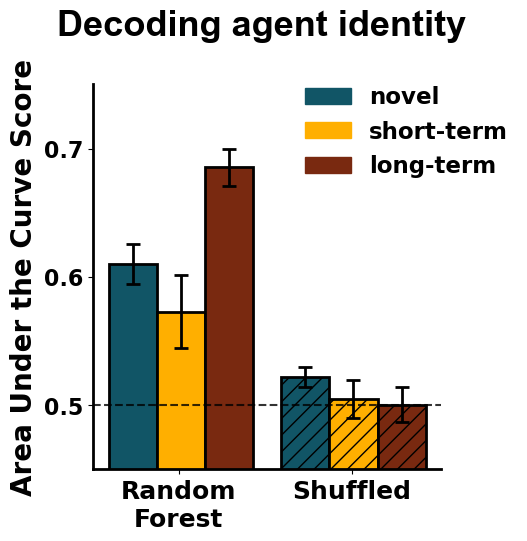

In [9]:


decoder_results = unpickle_this('phase3_agent_cups_aucs.pkl')
auc_100 = decoder_results[0]
auc_time_100 = decoder_results[2]
combined_dict_100 = {**auc_100, **auc_time_100}
onehundredms_dict = collapsed_auc_dict(auc_100, 0, 5, 100, 3)

avg_auc = {}
i = 1
no_plots = len(onehundredms_dict.keys())
height_fig = no_plots//2
categories = [ 'novel', 'familiar', 'cagemate'] # Example categories
categories_for_legend = [ 'novel', 'short-term', 'long-term']



avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for key in onehundredms_dict.keys():
    for category in categories:
        avg_values[category].append(np.mean(onehundredms_dict[key][category], axis=0))
        sem_values[category].append(sem(onehundredms_dict[key][category], axis=0))

bar_width = 0.25 # Width of each bar
x = np.arange(len(list(onehundredms_dict.keys())))  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(4.5, 5))
col = [hex_2_rgb('#115566'),
       hex_2_rgb('#FFAF00'),
       hex_2_rgb('#792910') ]
spacing = [0, -0.1]
edge = ['black','black', 'black', 'black', 'black', 'black']
for i, category in enumerate(categories):
    positions = x + (i+.32) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    hatches = ['','//','','//', '', '//', '', '//', '', '//', '', '//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j], width=bar_width, yerr=sem_values[category][j],
                capsize=5,linewidth = 2, 
                error_kw={'elinewidth': 2, 'capthick': 2},
                edgecolor=edge[i],
                alpha=alphas[j],
                label=category if i == 0 else '', color = col[i], hatch=hatches[j])
plt.ylim(0.45, 0.75)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend
# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [mpatches.Patch(color=col[i], label=categories_for_legend[i]) for i in range(len(col))]
# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 16.5, frameon= False, bbox_to_anchor=(0.55,1.05))
#title = '                                           Trained on >99% variance')
legend.get_title().set_fontsize('18') 
legend.get_title().set_ha('left')
#legend.get_title().set_position((-105, 1))
plt.xticks(x + spacing+0.32, onehundredms_dict.keys(), fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.suptitle('Decoding agent identity', fontsize = 26, font = 'Arial', y = 1.03)
plt.subplots_adjust(hspace=0.5)
plt.savefig('phase3_decoder.png', dpi = 600, transparent = True, bbox_inches='tight')

plt.show()

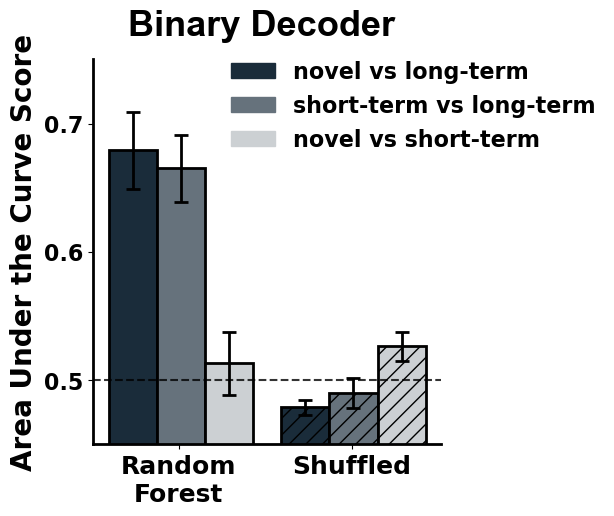

In [10]:
binary_auc_dict = unpickle_this('phase3_binary_auc.pkl')
binary_auc = binary_auc_dict['auc']
new_dict = collapsed_auc_dict(binary_auc, 0, 5, 100, 5)

pre_window = 5
equalize = 5
avg_auc = {}
i = 1
no_plots = len(new_dict.keys())
height_fig = no_plots//2
categories = ['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'] # Example categories



avg_values = {category: [] for category in categories}
sem_values = {category: [] for category in categories}
for key in new_dict.keys():
    for category in categories:
        avg_values[category].append(np.mean(new_dict[key][category], axis=0))
        sem_values[category].append(sem(new_dict[key][category], axis=0))

bar_width = 0.25  # Width of each bar
x = np.arange(len(list(new_dict.keys())))  # x-axis positions
legend_labels = {category: [] for category in categories}
plt.figure(figsize=(4.5, 5))
col = [ hex_2_rgb('#1a2c3a'),hex_2_rgb('#66727c'), hex_2_rgb('#ccd0d3') ]
spacing = [0, -.1]
edge = ['black', 'black','black', 'black']
for i, category in enumerate(categories):
    positions = x + (i -0.32) * bar_width  # Adjust positions for each category
    alphas = [1, 1, 1, 1]
    hatches = ['','//','','//']
    for j, pos in enumerate(positions):
        bar = plt.bar(pos + spacing[j], avg_values[category][j],
                      width=bar_width, yerr=sem_values[category][j],
                      capsize=5, edgecolor = edge[i], alpha=alphas[j],
                      hatch = hatches[j],linewidth = 2, 
                      error_kw={'elinewidth': 2, 'capthick': 2},
                      label=category if i == 0 else '', color = col[i])
plt.ylim(0.45, 0.75)
plt.yticks(fontsize=16)
for i, color in enumerate(col):
    plt.plot([], [], color=color, label=categories[i], linewidth=5)  # Empty plots to create the legend

# Create handles for the legend (rectangles as pseudo bars)
legend_patches = [mpatches.Patch(color=col[i], label=categories[i]) for i in range(len(col))]

# Add the custom legend with rectangles as pseudo bars
legend = plt.legend(handles=legend_patches, fontsize = 16, frameon= False, bbox_to_anchor=(1.5,1.05))
# legend.get_title().set_fontsize('18') 
# legend.get_title().set_ha('left')
# legend.get_title().set_position((-30, 1))
plt.xticks(x + spacing+0.16, new_dict.keys(), fontsize = 18)
plt.axhline(y=0.5, color='black', linestyle='--', alpha = 0.8)
plt.ylabel('Area Under the Curve Score', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.suptitle('Binary Decoder', fontsize = 26, font = 'Arial')
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.subplots_adjust(hspace=0.5)
plt.savefig('phase3_binary.png', dpi = 600, transparent = True, bbox_inches='tight')

plt.show()

## Stats

In [21]:
ttests = {}
categories = ['novel', 'familiar', 'cagemate'] # Example categories
for key in onehundredms_dict.keys():
    order_order = []
    agent_order = []
    order_ps = []
    agent_ps = []
    order_stats = []
    agent_stats = []
    for pair in combinations(categories, 2):
        agent_t_stat, agent_p_value = mannwhitneyu(onehundredms_dict[key][pair[0]],onehundredms_dict[key][pair[1]])
        agent_order.append(pair)
        agent_ps.append(agent_p_value)
        agent_stats.append(agent_t_stat)
        print(pair)
    agent_adj_p = multipletests(agent_ps, alpha=0.05, method='holm')[1]
    ttests[key] = {'agent': {'order':agent_order,
                             'stats': agent_stats,
                             'p value': agent_ps,
                             'adj p': agent_adj_p}}

expanded_rows = []

# Iterate through the nested dictionary
for key, nested_dict in ttests.items():
    for subkey, metrics in nested_dict.items():
        # Get the length of the lists (assuming all lists are of equal length)
        list_length = len(metrics['stats'])
        for i in range(list_length):
            row = {
                'key': key,
                'type': subkey,
                'order':metrics['order'][i],
                'stats': metrics['stats'][i],
                'p value': metrics['p value'][i],
                'adj p': metrics['adj p'][i]
            }
            expanded_rows.append(row)

# Create DataFrame from the expanded rows
df = pd.DataFrame(expanded_rows)

# Set MultiIndex
df = df.set_index(['key', 'type'])

df

('novel', 'familiar')
('novel', 'cagemate')
('familiar', 'cagemate')
('novel', 'familiar')
('novel', 'cagemate')
('familiar', 'cagemate')


order  stats   p value     adj p
key            type                                                  
Random\nForest agent     (novel, familiar)   17.0  0.420635  0.420635
               agent     (novel, cagemate)    0.0  0.007937  0.023810
               agent  (familiar, cagemate)    1.0  0.015873  0.031746
Shuffled       agent     (novel, familiar)   15.0  0.690476  1.000000
               agent     (novel, cagemate)   17.0  0.420635  1.000000
               agent  (familiar, cagemate)   14.0  0.841270  1.000000

In [14]:
ttests = {}
categories = ['novel vs long-term', 'short-term vs long-term', 'novel vs short-term'] # Example categories

for key in new_dict.keys():
    results = {}
    for pair in combinations(categories, 2):
        t_stat, p_value = ttest_rel(new_dict[key][pair[0]],new_dict[key][pair[1]])
        results[pair] = [t_stat, p_value]
    ttests[key] = results

ttess_df = pd.DataFrame.from_dict(ttests)
print(ttess_df)

                                                                               Random\nForest  \
novel vs long-term      short-term vs long-term     [0.41853069588403763, 0.6970540402622101]   
                        novel vs short-term      [12.466108470071465, 0.00023813478642805317]   
short-term vs long-term novel vs short-term         [5.527189684806709, 0.005234104586708605]   

                                                                                   Shuffled  
novel vs long-term      short-term vs long-term    [-0.692218836554998, 0.5268850067943682]  
                        novel vs short-term      [-5.588114300269132, 0.005030691176221143]  
short-term vs long-term novel vs short-term       [-2.204512694335004, 0.09218783628244862]  
